In [ ]:
# [CLS]トークンを利用
# 自作のセパレータ
# add_special_tokens
# epochs: 4->5

In [ ]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='024'
    wandb=True
    resume='must'  # [None, 'auto', 'allow', 'must']
    run_id='1x2eka0f'
    save_checkpoint=True
    competition='PPPM'
    debug=False  # False
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[1]
    epochs=5
    gradient_accumulation_steps=1
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = False  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [ ]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Wed Jun 15 03:50:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [ ]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 58 kB 2.6 MB/s 
CPU times: user 1.82 s, sys: 399 ms, total: 2.22 s
Wall time: 28.9 s


In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [ ]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    !pip install -q wandb
    import wandb

    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        with open('/content/drive/MyDrive/kaggle/wandb') as f:
           wandb_api_key = f.readline().rstrip('\n')
        wandb.login(key=wandb_api_key)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                     name=CFG.exp,
                     config=class2dict(CFG),
                    #  group=CFG.exp,
                     job_type="train",
                     resume=CFG.resume,
                     id=CFG.run_id,
                     anonymous=anony)

     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 181 kB 45.7 MB/s 
     |████████████████████████████████| 145 kB 38.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin


# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [ ]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [ ]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)

display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


# EDA

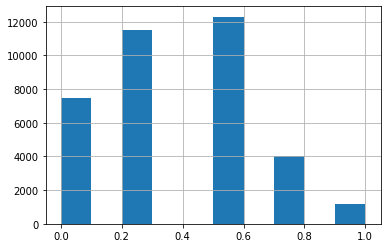

In [ ]:
train['score'].hist()

In [ ]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [ ]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [ ]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [ ]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
num_added_tokens = tokenizer.add_special_tokens({'additional_special_tokens': ["[s]"]})
print(f"{num_added_tokens} tokens added.")
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1 tokens added.


In [ ]:
# 入力テキストを生成

# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text
train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

train['section'] = train['context'].map(lambda s: s[0])
test['section'] = test['context'].map(lambda s: s[0])
train['sectok'] = '[' + train['section'] + ']'
test['sectok'] = '[' + test['section'] + ']'

# anchor, target, context_text をそれぞれ一文ずつとみなす
sep = '[s]'
print(sep)
train['text'] = train['anchor'] + '.' + sep + train['target'] + '.' + sep  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + sep + test['target'] + '.' + sep  + test['context_text'] + '.'
display(train.head())
display(test.head())

[s]


,id,anchor,target,context,score,context_text,fold,section,sectok,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,0,A,[A],abatement.[s]abatement of pollution.[s]HUMAN N...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,0,A,[A],abatement.[s]act of abating.[s]HUMAN NECESSITI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,0,A,[A],abatement.[s]active catalyst.[s]HUMAN NECESSIT...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,0,A,[A],abatement.[s]eliminating process.[s]HUMAN NECE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,0,A,[A],abatement.[s]forest region.[s]HUMAN NECESSITIE...


,id,anchor,target,context,context_text,section,sectok,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,G,[G],opc drum.[s]inorganic photoconductor drum.[s]P...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,F,[F],adjust gas flow.[s]altering gas flow.[s]MECHAN...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,B,[B],lower trunnion.[s]lower locating.[s]PERFORMING...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,D,[D],cap component.[s]upper portion.[s]TEXTILES. PA...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,H,[H],neural stimulation.[s]artificial neural networ...


# Dataset

In [ ]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 106


In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [ ]:
# train_dataset = TrainDataset(CFG, train, 'train')
# inputs, label = train_dataset[0]
# print(inputs)
# print(label)

# Model

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.model.resize_token_embeddings(len(cfg.tokenizer))
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]  # (bs, max_len, hidden_size)
        feature = last_hidden_states[:, 0, :]  # [CLS]トークンを利用
        # feature = torch.mean(last_hidden_states, dim=1)  # 全トークンを平均
        # weights = self.attention(last_hidden_states)
        # feature = torch.sum(weights * last_hidden_states, dim=1)  # 全トークンをattentionレイヤで加重平均
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    # 全エポックでのステップ数
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    # if wandb.run.resumed:
    #     checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
    #     model.load_state_dict(checkpoint['model'])
    #     optimizer.load_state_dict(checkpoint['model'])
    #     scheduler.load_state_dict(checkpoint['scheduler'])
    #     # amp.load_state_dict(checkpoint['amp'])
    #     epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
    #     best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        # if wandb.run.resumed:
        #     checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
        #     fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
        #     oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1693] Elapsed 0m 1s (remain 30m 35s) Loss: 0.7160(0.7160) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1693] Elapsed 1m 20s (remain 21m 11s) Loss: 0.6748(0.6451) Grad: 70546.0234  LR: 0.00001999  
Epoch: [1][200/1693] Elapsed 2m 39s (remain 19m 42s) Loss: 0.5674(0.6303) Grad: 19365.3887  LR: 0.00001997  
Epoch: [1][300/1693] Elapsed 3m 58s (remain 18m 21s) Loss: 0.5571(0.6124) Grad: 16625.0488  LR: 0.00001994  
Epoch: [1][400/1693] Elapsed 5m 16s (remain 17m 0s) Loss: 0.6493(0.6033) Grad: 21450.4512  LR: 0.00001989  
Epoch: [1][500/1693] Elapsed 6m 35s (remain 15m 41s) Loss: 0.4912(0.5974) Grad: 19444.9395  LR: 0.00001983  
Epoch: [1][600/1693] Elapsed 7m 54s (remain 14m 22s) Loss: 0.4706(0.5927) Grad: 5288.7480  LR: 0.00001975  
Epoch: [1][700/1693] Elapsed 9m 13s (remain 13m 3s) Loss: 0.4846(0.5887) Grad: 11093.3379  LR: 0.00001966  
Epoch: [1][800/1693] Elapsed 10m 32s (remain 11m 44s) Loss: 0.6632(0.5840) Grad: 43406.7383  LR: 0.00001956  
Epoch: [1][900/1693] Elapsed 11

Epoch 1 - avg_train_loss: 0.5650  avg_val_loss: 0.5469  time: 1456s
Epoch 1 - Score: 0.8214


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.6819(0.5469) 


Epoch 1 - Save Best Score: 0.8214 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 37m 52s) Loss: 0.5926(0.5926) Grad: 82303.4688  LR: 0.00001809  
Epoch: [2][100/1693] Elapsed 1m 27s (remain 22m 51s) Loss: 0.5640(0.5214) Grad: 151322.7031  LR: 0.00001786  
Epoch: [2][200/1693] Elapsed 2m 47s (remain 20m 40s) Loss: 0.5106(0.5161) Grad: 54915.7422  LR: 0.00001763  
Epoch: [2][300/1693] Elapsed 4m 5s (remain 18m 56s) Loss: 0.4631(0.5171) Grad: 44835.6680  LR: 0.00001739  
Epoch: [2][400/1693] Elapsed 5m 24s (remain 17m 26s) Loss: 0.4557(0.5157) Grad: 118573.9531  LR: 0.00001713  
Epoch: [2][500/1693] Elapsed 6m 44s (remain 16m 3s) Loss: 0.5716(0.5192) Grad: 106241.5391  LR: 0.00001686  
Epoch: [2][600/1693] Elapsed 8m 4s (remain 14m 39s) Loss: 0.5503(0.5192) Grad: 136108.8281  LR: 0.00001659  
Epoch: [2][700/1693] Elapsed 9m 23s (remain 13m 16s) Loss: 0.5025(0.5204) Grad: 45487.4023  LR: 0.00001631  
Epoch: [2][800/1693] Elapsed 10m 41s (remain 11m 54s) Loss: 0.5802(0.5211) Grad: 133066.9844  LR: 0.00001601  
Epoch: [2][900/1693

Epoch 2 - avg_train_loss: 0.5204  avg_val_loss: 0.5503  time: 1468s
Epoch 2 - Score: 0.8350


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.6783(0.5503) 


Epoch 2 - Save Best Score: 0.8350 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 36m 19s) Loss: 0.6267(0.6267) Grad: 51028.5469  LR: 0.00001309  
Epoch: [3][100/1693] Elapsed 1m 23s (remain 21m 57s) Loss: 0.4565(0.5161) Grad: 107976.1406  LR: 0.00001273  
Epoch: [3][200/1693] Elapsed 2m 44s (remain 20m 24s) Loss: 0.4324(0.5103) Grad: 56492.0117  LR: 0.00001237  
Epoch: [3][300/1693] Elapsed 4m 3s (remain 18m 47s) Loss: 0.5448(0.5110) Grad: 94251.2266  LR: 0.00001201  
Epoch: [3][400/1693] Elapsed 5m 22s (remain 17m 19s) Loss: 0.4504(0.5131) Grad: 38922.3984  LR: 0.00001165  
Epoch: [3][500/1693] Elapsed 6m 41s (remain 15m 55s) Loss: 0.5008(0.5143) Grad: 108511.7109  LR: 0.00001128  
Epoch: [3][600/1693] Elapsed 8m 0s (remain 14m 32s) Loss: 0.5858(0.5143) Grad: 86115.4688  LR: 0.00001091  
Epoch: [3][700/1693] Elapsed 9m 19s (remain 13m 11s) Loss: 0.4334(0.5120) Grad: 97178.3828  LR: 0.00001054  
Epoch: [3][800/1693] Elapsed 10m 37s (remain 11m 50s) Loss: 0.5580(0.5121) Grad: 60729.5273  LR: 0.00001017  
Epoch: [3][900/1693] 

Epoch 3 - avg_train_loss: 0.5097  avg_val_loss: 0.5543  time: 1462s
Epoch 3 - Score: 0.8359


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.6837(0.5543) 


Epoch 3 - Save Best Score: 0.8359 Model


Epoch: [4][0/1693] Elapsed 0m 1s (remain 33m 55s) Loss: 0.5392(0.5392) Grad: 289872.7188  LR: 0.00000691  
Epoch: [4][100/1693] Elapsed 1m 23s (remain 22m 0s) Loss: 0.4534(0.5012) Grad: 80605.8516  LR: 0.00000656  
Epoch: [4][200/1693] Elapsed 2m 45s (remain 20m 27s) Loss: 0.5076(0.4990) Grad: 693135.2500  LR: 0.00000621  
Epoch: [4][300/1693] Elapsed 4m 4s (remain 18m 49s) Loss: 0.5100(0.5000) Grad: 38003.0391  LR: 0.00000587  
Epoch: [4][400/1693] Elapsed 5m 23s (remain 17m 21s) Loss: 0.5060(0.5017) Grad: 65550.8438  LR: 0.00000554  
Epoch: [4][500/1693] Elapsed 6m 42s (remain 15m 56s) Loss: 0.4795(0.5028) Grad: 67816.1094  LR: 0.00000521  
Epoch: [4][600/1693] Elapsed 8m 0s (remain 14m 33s) Loss: 0.4518(0.5036) Grad: 67632.2188  LR: 0.00000488  
Epoch: [4][700/1693] Elapsed 9m 20s (remain 13m 12s) Loss: 0.4369(0.5036) Grad: 50099.5469  LR: 0.00000457  
Epoch: [4][800/1693] Elapsed 10m 38s (remain 11m 51s) Loss: 0.4774(0.5037) Grad: 94891.9609  LR: 0.00000426  
Epoch: [4][900/1693] E

Epoch 4 - avg_train_loss: 0.5025  avg_val_loss: 0.5588  time: 1464s
Epoch 4 - Score: 0.8366


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.6784(0.5588) 


Epoch 4 - Save Best Score: 0.8366 Model


Epoch: [5][0/1693] Elapsed 0m 1s (remain 38m 8s) Loss: 0.5286(0.5286) Grad: 65607.8438  LR: 0.00000191  
Epoch: [5][100/1693] Elapsed 1m 24s (remain 22m 10s) Loss: 0.5502(0.4923) Grad: 106768.8438  LR: 0.00000170  
Epoch: [5][200/1693] Elapsed 2m 46s (remain 20m 34s) Loss: 0.4565(0.4945) Grad: 85436.0000  LR: 0.00000150  
Epoch: [5][300/1693] Elapsed 4m 5s (remain 18m 54s) Loss: 0.4210(0.4954) Grad: 31792.3496  LR: 0.00000131  
Epoch: [5][400/1693] Elapsed 5m 24s (remain 17m 24s) Loss: 0.4278(0.4937) Grad: 106145.5703  LR: 0.00000113  
Epoch: [5][500/1693] Elapsed 6m 43s (remain 15m 59s) Loss: 0.4990(0.4979) Grad: 17875.8574  LR: 0.00000096  
Epoch: [5][600/1693] Elapsed 8m 1s (remain 14m 35s) Loss: 0.4173(0.4990) Grad: 90774.1328  LR: 0.00000081  
Epoch: [5][700/1693] Elapsed 9m 20s (remain 13m 13s) Loss: 0.5970(0.4981) Grad: 74472.3281  LR: 0.00000067  
Epoch: [5][800/1693] Elapsed 10m 39s (remain 11m 52s) Loss: 0.5337(0.4980) Grad: 64452.2461  LR: 0.00000054  
Epoch: [5][900/1693] E

Epoch 5 - avg_train_loss: 0.4978  avg_val_loss: 0.5610  time: 1465s
Epoch 5 - Score: 0.8362


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.6782(0.5610) 


========== fold: 0 result ==========
Score: 0.8366
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1725] Elapsed 0m 1s (remain 46m 44s) Loss: 0.7171(0.7171) Grad: 142411.9062  LR: 0.00002000  
Epoch: [1][100/1725] Elapsed 1m 24s (remain 22m 45s) Loss: 0.5702(0.6472) Grad: 73202.3828  LR: 0.00001999  
Epoch: [1][200/1725] Elapsed 2m 43s (remain 20m 42s) Loss: 0.6859(0.6412) Grad: 3934.2334  LR: 0.00001997  
Epoch: [1][300/1725] Elapsed 4m 2s (remain 19m 7s) Loss: 0.6306(0.6496) Grad: 15230.5889  LR: 0.00001994  
Epoch: [1][400/1725] Elapsed 5m 21s (remain 17m 41s) Loss: 0.5974(0.6547) Grad: 5858.8149  LR: 0.00001989  
Epoch: [1][500/1725] Elapsed 6m 40s (remain 16m 18s) Loss: 0.6443(0.6581) Grad: 4605.2554  LR: 0.00001983  
Epoch: [1][600/1725] Elapsed 7m 59s (remain 14m 56s) Loss: 0.6820(0.6584) Grad: 10124.2031  LR: 0.00001976  
Epoch: [1][700/1725] Elapsed 9m 17s (remain 13m 35s) Loss: 0.6159(0.6590) Grad: 8175.2866  LR: 0.00001968  
Epoch: [1][800/1725] Elapsed 10m 36s (remain 12m 14s) Loss: 0.6530(0.6600) Grad: 6049.7690  LR: 0.00001958  
Epoch: [1][900/1725] Elapse

Epoch 1 - avg_train_loss: 0.6611  avg_val_loss: 0.6589  time: 1480s
Epoch 1 - Score: -0.0203


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.8299(0.6589) 
Epoch: [2][0/1725] Elapsed 0m 1s (remain 32m 39s) Loss: 0.6949(0.6949) Grad: 144974.1094  LR: 0.00001809  
Epoch: [2][100/1725] Elapsed 1m 23s (remain 22m 23s) Loss: 0.7154(0.6646) Grad: 48863.9375  LR: 0.00001787  
Epoch: [2][200/1725] Elapsed 2m 44s (remain 20m 44s) Loss: 0.6151(0.6596) Grad: 20373.0898  LR: 0.00001764  
Epoch: [2][300/1725] Elapsed 4m 2s (remain 19m 9s) Loss: 0.6476(0.6613) Grad: 16802.0254  LR: 0.00001740  
Epoch: [2][400/1725] Elapsed 5m 21s (remain 17m 42s) Loss: 0.6366(0.6606) Grad: 24220.3516  LR: 0.00001715  
Epoch: [2][500/1725] Elapsed 6m 40s (remain 16m 18s) Loss: 0.6330(0.6599) Grad: 14557.0752  LR: 0.00001689  
Epoch: [2][600/1725] Elapsed 7m 59s (remain 14m 56s) Loss: 0.6244(0.6589) Grad: 12119.6777  LR: 0.00001662  
Epoch: [2][700/1725] Elapsed 9m 18s (remain 13m 35s) Loss: 0.7235(0.6589) Grad: 36330.3008  LR: 0.00001635  
Epoch: [2][800/1725] Elapsed 10m 37s (remain 12m 15s) Loss: 0.65

Epoch 2 - avg_train_loss: 0.6592  avg_val_loss: 0.6561  time: 1480s
Epoch 2 - Score: 0.0223


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.7969(0.6561) 


Epoch 2 - Save Best Score: 0.0223 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 40m 6s) Loss: 0.7204(0.7204) Grad: 146753.8125  LR: 0.00001309  
Epoch: [3][100/1725] Elapsed 1m 26s (remain 23m 16s) Loss: 0.5934(0.6584) Grad: 39539.5859  LR: 0.00001274  
Epoch: [3][200/1725] Elapsed 2m 47s (remain 21m 9s) Loss: 0.6117(0.6572) Grad: 15695.0830  LR: 0.00001239  
Epoch: [3][300/1725] Elapsed 4m 6s (remain 19m 26s) Loss: 0.6423(0.6589) Grad: 8858.0703  LR: 0.00001204  
Epoch: [3][400/1725] Elapsed 5m 26s (remain 17m 56s) Loss: 0.7145(0.6594) Grad: 23326.7148  LR: 0.00001168  
Epoch: [3][500/1725] Elapsed 6m 45s (remain 16m 30s) Loss: 0.6580(0.6595) Grad: 9097.8984  LR: 0.00001132  
Epoch: [3][600/1725] Elapsed 8m 4s (remain 15m 6s) Loss: 0.6478(0.6592) Grad: 9543.9414  LR: 0.00001096  
Epoch: [3][700/1725] Elapsed 9m 23s (remain 13m 43s) Loss: 0.6559(0.6584) Grad: 7571.8496  LR: 0.00001059  
Epoch: [3][800/1725] Elapsed 10m 43s (remain 12m 21s) Loss: 0.6741(0.6577) Grad: 9395.0176  LR: 0.00001023  
Epoch: [3][900/1725] Elapsed 1

Epoch 3 - avg_train_loss: 0.6575  avg_val_loss: 0.6560  time: 1490s
Epoch 3 - Score: 0.0474


EVAL: [553/554] Elapsed 1m 54s (remain 0m 0s) Loss: 0.7898(0.6560) 


Epoch 3 - Save Best Score: 0.0474 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 39m 39s) Loss: 0.6339(0.6339) Grad: inf  LR: 0.00000691  
Epoch: [4][100/1725] Elapsed 1m 25s (remain 22m 46s) Loss: 0.6754(0.6565) Grad: 13738.8311  LR: 0.00000657  
Epoch: [4][200/1725] Elapsed 2m 47s (remain 21m 8s) Loss: 0.7326(0.6564) Grad: 29820.3047  LR: 0.00000623  
Epoch: [4][300/1725] Elapsed 4m 6s (remain 19m 27s) Loss: 0.6535(0.6574) Grad: 11818.2324  LR: 0.00000590  
Epoch: [4][400/1725] Elapsed 5m 26s (remain 17m 57s) Loss: 0.7062(0.6582) Grad: 23798.0117  LR: 0.00000557  
Epoch: [4][500/1725] Elapsed 6m 45s (remain 16m 31s) Loss: 0.6229(0.6576) Grad: 21800.2988  LR: 0.00000524  
Epoch: [4][600/1725] Elapsed 8m 5s (remain 15m 7s) Loss: 0.6044(0.6580) Grad: 24671.2617  LR: 0.00000493  
Epoch: [4][700/1725] Elapsed 9m 24s (remain 13m 44s) Loss: 0.6164(0.6577) Grad: 18525.4609  LR: 0.00000462  
Epoch: [4][800/1725] Elapsed 10m 44s (remain 12m 23s) Loss: 0.7208(0.6581) Grad: 37330.4336  LR: 0.00000431  
Epoch: [4][900/1725] Elapsed 12m

Epoch 4 - avg_train_loss: 0.6565  avg_val_loss: 0.6562  time: 1492s
Epoch 4 - Score: 0.0432


EVAL: [553/554] Elapsed 1m 54s (remain 0m 0s) Loss: 0.7989(0.6562) 
Epoch: [5][0/1725] Elapsed 0m 1s (remain 33m 53s) Loss: 0.6406(0.6406) Grad: 69077.8984  LR: 0.00000191  
Epoch: [5][100/1725] Elapsed 1m 25s (remain 22m 47s) Loss: 0.6932(0.6468) Grad: 15503.7783  LR: 0.00000171  
Epoch: [5][200/1725] Elapsed 2m 45s (remain 20m 55s) Loss: 0.6535(0.6494) Grad: 8160.2603  LR: 0.00000151  
Epoch: [5][300/1725] Elapsed 4m 4s (remain 19m 17s) Loss: 0.6763(0.6521) Grad: 12193.1221  LR: 0.00000132  
Epoch: [5][400/1725] Elapsed 5m 24s (remain 17m 51s) Loss: 0.5921(0.6540) Grad: 38881.4570  LR: 0.00000115  
Epoch: [5][500/1725] Elapsed 6m 43s (remain 16m 26s) Loss: 0.5862(0.6535) Grad: 24616.2070  LR: 0.00000098  
Epoch: [5][600/1725] Elapsed 8m 2s (remain 15m 3s) Loss: 0.6150(0.6544) Grad: 23315.0176  LR: 0.00000083  
Epoch: [5][700/1725] Elapsed 9m 22s (remain 13m 41s) Loss: 0.6980(0.6549) Grad: 13007.5732  LR: 0.00000069  
Epoch: [5][800/1725] Elapsed 10m 41s (remain 12m 20s) Loss: 0.6237(

Epoch 5 - avg_train_loss: 0.6558  avg_val_loss: 0.6560  time: 1489s
Epoch 5 - Score: 0.0480


EVAL: [553/554] Elapsed 1m 54s (remain 0m 0s) Loss: 0.7911(0.6560) 


Epoch 5 - Save Best Score: 0.0480 Model
========== fold: 1 result ==========
Score: 0.0480
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exact

Epoch: [1][0/1741] Elapsed 0m 1s (remain 41m 47s) Loss: 0.7108(0.7108) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1741] Elapsed 1m 24s (remain 22m 51s) Loss: 0.6223(0.6585) Grad: 86234.0859  LR: 0.00001999  
Epoch: [1][200/1741] Elapsed 2m 45s (remain 21m 9s) Loss: 0.4686(0.6344) Grad: 48220.5586  LR: 0.00001997  
Epoch: [1][300/1741] Elapsed 4m 4s (remain 19m 31s) Loss: 0.5698(0.6227) Grad: 114220.0078  LR: 0.00001994  
Epoch: [1][400/1741] Elapsed 5m 24s (remain 18m 3s) Loss: 0.5488(0.6088) Grad: 102478.6875  LR: 0.00001990  
Epoch: [1][500/1741] Elapsed 6m 43s (remain 16m 38s) Loss: 0.5652(0.6015) Grad: 64966.1641  LR: 0.00001984  
Epoch: [1][600/1741] Elapsed 8m 2s (remain 15m 15s) Loss: 0.6318(0.5977) Grad: 67395.1172  LR: 0.00001977  
Epoch: [1][700/1741] Elapsed 9m 22s (remain 13m 53s) Loss: 0.6560(0.5931) Grad: 125364.7031  LR: 0.00001968  
Epoch: [1][800/1741] Elapsed 10m 41s (remain 12m 32s) Loss: 0.5666(0.5894) Grad: 82437.1719  LR: 0.00001959  
Epoch: [1][900/1741] Elapsed 

Epoch 1 - avg_train_loss: 0.5712  avg_val_loss: 0.5415  time: 1498s
Epoch 1 - Score: 0.8355


EVAL: [538/539] Elapsed 1m 51s (remain 0m 0s) Loss: 0.3514(0.5415) 


Epoch 1 - Save Best Score: 0.8355 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 45m 28s) Loss: 0.4764(0.4764) Grad: 73097.6797  LR: 0.00001809  
Epoch: [2][100/1741] Elapsed 1m 26s (remain 23m 28s) Loss: 0.4896(0.5258) Grad: 109678.4219  LR: 0.00001787  
Epoch: [2][200/1741] Elapsed 2m 46s (remain 21m 15s) Loss: 0.5491(0.5336) Grad: 44324.5078  LR: 0.00001764  
Epoch: [2][300/1741] Elapsed 4m 5s (remain 19m 35s) Loss: 0.6014(0.5329) Grad: 94723.7500  LR: 0.00001741  
Epoch: [2][400/1741] Elapsed 5m 24s (remain 18m 5s) Loss: 0.5113(0.5314) Grad: 56960.1094  LR: 0.00001716  
Epoch: [2][500/1741] Elapsed 6m 44s (remain 16m 40s) Loss: 0.5026(0.5332) Grad: 49928.2188  LR: 0.00001690  
Epoch: [2][600/1741] Elapsed 8m 3s (remain 15m 16s) Loss: 0.5467(0.5341) Grad: 33546.2852  LR: 0.00001664  
Epoch: [2][700/1741] Elapsed 9m 22s (remain 13m 54s) Loss: 0.5954(0.5335) Grad: 77152.8594  LR: 0.00001636  
Epoch: [2][800/1741] Elapsed 10m 41s (remain 12m 33s) Loss: 0.5210(0.5328) Grad: 51425.2930  LR: 0.00001608  
Epoch: [2][900/1741] El

Epoch 2 - avg_train_loss: 0.5317  avg_val_loss: 0.5446  time: 1495s
Epoch 2 - Score: 0.8318


EVAL: [538/539] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3471(0.5446) 
Epoch: [3][0/1741] Elapsed 0m 1s (remain 34m 29s) Loss: 0.5336(0.5336) Grad: 157390.2500  LR: 0.00001309  
Epoch: [3][100/1741] Elapsed 1m 23s (remain 22m 38s) Loss: 0.5996(0.5089) Grad: 1386470.7500  LR: 0.00001274  
Epoch: [3][200/1741] Elapsed 2m 44s (remain 20m 59s) Loss: 0.5385(0.5099) Grad: 84956.2734  LR: 0.00001239  
Epoch: [3][300/1741] Elapsed 4m 3s (remain 19m 26s) Loss: 0.5647(0.5112) Grad: 53120.2188  LR: 0.00001204  
Epoch: [3][400/1741] Elapsed 5m 22s (remain 17m 58s) Loss: 0.4130(0.5116) Grad: 45107.3555  LR: 0.00001169  
Epoch: [3][500/1741] Elapsed 6m 41s (remain 16m 34s) Loss: 0.4513(0.5118) Grad: 128868.9688  LR: 0.00001133  
Epoch: [3][600/1741] Elapsed 8m 0s (remain 15m 11s) Loss: 0.4219(0.5142) Grad: 43235.1016  LR: 0.00001097  
Epoch: [3][700/1741] Elapsed 9m 19s (remain 13m 49s) Loss: 0.4593(0.5127) Grad: 206645.0312  LR: 0.00001061  
Epoch: [3][800/1741] Elapsed 10m 38s (remain 12m 29s) Loss: 

Epoch 3 - avg_train_loss: 0.5131  avg_val_loss: 0.5476  time: 1492s
Epoch 3 - Score: 0.8437
Epoch 3 - Save Best Score: 0.8437 Model


Epoch: [4][0/1741] Elapsed 0m 1s (remain 44m 51s) Loss: 0.5573(0.5573) Grad: 118035.1562  LR: 0.00000691  
Epoch: [4][100/1741] Elapsed 1m 23s (remain 22m 40s) Loss: 0.4116(0.5062) Grad: 87381.6953  LR: 0.00000657  
Epoch: [4][200/1741] Elapsed 2m 45s (remain 21m 8s) Loss: 0.5574(0.5052) Grad: 74332.2422  LR: 0.00000623  
Epoch: [4][300/1741] Elapsed 4m 4s (remain 19m 31s) Loss: 0.4805(0.5035) Grad: 60922.7422  LR: 0.00000590  
Epoch: [4][400/1741] Elapsed 5m 24s (remain 18m 2s) Loss: 0.4394(0.5040) Grad: 392499.6875  LR: 0.00000557  
Epoch: [4][500/1741] Elapsed 6m 42s (remain 16m 37s) Loss: 0.4563(0.5042) Grad: 48686.8477  LR: 0.00000525  
Epoch: [4][600/1741] Elapsed 8m 1s (remain 15m 13s) Loss: 0.5775(0.5045) Grad: 46300.7109  LR: 0.00000494  
Epoch: [4][700/1741] Elapsed 9m 20s (remain 13m 51s) Loss: 0.4611(0.5037) Grad: 52365.3984  LR: 0.00000463  
Epoch: [4][800/1741] Elapsed 10m 39s (remain 12m 30s) Loss: 0.3884(0.5040) Grad: 297401.9375  LR: 0.00000433  
Epoch: [4][900/1741] E

Epoch 4 - avg_train_loss: 0.5035  avg_val_loss: 0.5479  time: 1493s
Epoch 4 - Score: 0.8448


EVAL: [538/539] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3407(0.5479) 


Epoch 4 - Save Best Score: 0.8448 Model


Epoch: [5][0/1741] Elapsed 0m 1s (remain 36m 13s) Loss: 0.5551(0.5551) Grad: 105818.1094  LR: 0.00000191  
Epoch: [5][100/1741] Elapsed 1m 24s (remain 22m 51s) Loss: 0.5098(0.4979) Grad: 34729.0703  LR: 0.00000170  
Epoch: [5][200/1741] Elapsed 2m 46s (remain 21m 13s) Loss: 0.5639(0.4968) Grad: 96497.3125  LR: 0.00000151  
Epoch: [5][300/1741] Elapsed 4m 5s (remain 19m 34s) Loss: 0.4258(0.4983) Grad: 32193.3652  LR: 0.00000132  
Epoch: [5][400/1741] Elapsed 5m 24s (remain 18m 5s) Loss: 0.4546(0.4972) Grad: 74874.2891  LR: 0.00000115  
Epoch: [5][500/1741] Elapsed 6m 43s (remain 16m 39s) Loss: 0.5055(0.4994) Grad: 55229.8008  LR: 0.00000099  
Epoch: [5][600/1741] Elapsed 8m 2s (remain 15m 15s) Loss: 0.5049(0.4993) Grad: 51950.8750  LR: 0.00000084  
Epoch: [5][700/1741] Elapsed 9m 21s (remain 13m 52s) Loss: 0.5317(0.4991) Grad: 78672.2812  LR: 0.00000070  
Epoch: [5][800/1741] Elapsed 10m 40s (remain 12m 31s) Loss: 0.5932(0.4997) Grad: 63771.5430  LR: 0.00000057  
Epoch: [5][900/1741] El

Epoch 5 - avg_train_loss: 0.4995  avg_val_loss: 0.5505  time: 1492s
Epoch 5 - Score: 0.8436


EVAL: [538/539] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3407(0.5505) 


========== fold: 2 result ==========
Score: 0.8448
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1678] Elapsed 0m 1s (remain 43m 51s) Loss: 0.7748(0.7748) Grad: 154554.2500  LR: 0.00002000  
Epoch: [1][100/1678] Elapsed 1m 23s (remain 21m 49s) Loss: 0.5270(0.6456) Grad: 45919.2617  LR: 0.00001999  
Epoch: [1][200/1678] Elapsed 2m 42s (remain 19m 56s) Loss: 0.6437(0.6222) Grad: 18384.9668  LR: 0.00001997  
Epoch: [1][300/1678] Elapsed 4m 1s (remain 18m 26s) Loss: 0.6569(0.6099) Grad: 27800.0176  LR: 0.00001994  
Epoch: [1][400/1678] Elapsed 5m 20s (remain 17m 1s) Loss: 0.5441(0.5984) Grad: 10759.4209  LR: 0.00001989  
Epoch: [1][500/1678] Elapsed 6m 39s (remain 15m 38s) Loss: 0.4780(0.5890) Grad: 13731.2334  LR: 0.00001982  
Epoch: [1][600/1678] Elapsed 7m 58s (remain 14m 17s) Loss: 0.5425(0.5836) Grad: 11469.2363  LR: 0.00001975  
Epoch: [1][700/1678] Elapsed 9m 17s (remain 12m 57s) Loss: 0.5194(0.5785) Grad: 21001.7285  LR: 0.00001966  
Epoch: [1][800/1678] Elapsed 10m 36s (remain 11m 36s) Loss: 0.6153(0.5763) Grad: 15316.2236  LR: 0.00001955  
Epoch: [1][900/1678] E

Epoch 1 - avg_train_loss: 0.5604  avg_val_loss: 0.5560  time: 1453s
Epoch 1 - Score: 0.7934
Epoch 1 - Save Best Score: 0.7934 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 42m 39s) Loss: 0.4832(0.4832) Grad: 62071.0742  LR: 0.00001809  
Epoch: [2][100/1678] Elapsed 1m 25s (remain 22m 17s) Loss: 0.4352(0.5215) Grad: 17542.0898  LR: 0.00001786  
Epoch: [2][200/1678] Elapsed 2m 45s (remain 20m 16s) Loss: 0.5822(0.5226) Grad: 13442.4854  LR: 0.00001763  
Epoch: [2][300/1678] Elapsed 4m 4s (remain 18m 38s) Loss: 0.6485(0.5205) Grad: 32986.5703  LR: 0.00001738  
Epoch: [2][400/1678] Elapsed 5m 23s (remain 17m 11s) Loss: 0.5020(0.5193) Grad: 43825.9922  LR: 0.00001712  
Epoch: [2][500/1678] Elapsed 6m 42s (remain 15m 46s) Loss: 0.5478(0.5166) Grad: 33541.0508  LR: 0.00001685  
Epoch: [2][600/1678] Elapsed 8m 1s (remain 14m 23s) Loss: 0.4906(0.5175) Grad: 29763.9824  LR: 0.00001657  
Epoch: [2][700/1678] Elapsed 9m 20s (remain 13m 1s) Loss: 0.5210(0.5188) Grad: 13322.2012  LR: 0.00001629  
Epoch: [2][800/1678] Elapsed 10m 39s (remain 11m 40s) Loss: 0.6034(0.5190) Grad: 59021.1094  LR: 0.00001599  
Epoch: [2][900/1678] Ela

Epoch 2 - avg_train_loss: 0.5193  avg_val_loss: 0.5604  time: 1456s
Epoch 2 - Score: 0.8075
Epoch 2 - Save Best Score: 0.8075 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 37m 7s) Loss: 0.5151(0.5151) Grad: inf  LR: 0.00001309  
Epoch: [3][100/1678] Elapsed 1m 23s (remain 21m 43s) Loss: 0.5379(0.5063) Grad: 27436.1133  LR: 0.00001273  
Epoch: [3][200/1678] Elapsed 2m 44s (remain 20m 11s) Loss: 0.3543(0.5023) Grad: 16298.2314  LR: 0.00001237  
Epoch: [3][300/1678] Elapsed 4m 4s (remain 18m 36s) Loss: 0.6460(0.5011) Grad: 132309.4844  LR: 0.00001200  
Epoch: [3][400/1678] Elapsed 5m 23s (remain 17m 8s) Loss: 0.3826(0.5014) Grad: 11228.5117  LR: 0.00001163  
Epoch: [3][500/1678] Elapsed 6m 42s (remain 15m 45s) Loss: 0.4750(0.5034) Grad: 35324.6797  LR: 0.00001126  
Epoch: [3][600/1678] Elapsed 8m 1s (remain 14m 22s) Loss: 0.4175(0.5024) Grad: 20834.6680  LR: 0.00001089  
Epoch: [3][700/1678] Elapsed 9m 20s (remain 13m 0s) Loss: 0.4629(0.5029) Grad: 22709.9121  LR: 0.00001052  
Epoch: [3][800/1678] Elapsed 10m 39s (remain 11m 39s) Loss: 0.3922(0.5027) Grad: 12271.8340  LR: 0.00001014  
Epoch: [3][900/1678] Elapsed 11m

Epoch 3 - avg_train_loss: 0.5055  avg_val_loss: 0.5652  time: 1455s
Epoch 3 - Score: 0.8125
Epoch 3 - Save Best Score: 0.8125 Model


Epoch: [4][0/1678] Elapsed 0m 1s (remain 42m 5s) Loss: 0.5776(0.5776) Grad: 31167.4590  LR: 0.00000691  
Epoch: [4][100/1678] Elapsed 1m 23s (remain 21m 46s) Loss: 0.4860(0.5008) Grad: 19729.1777  LR: 0.00000655  
Epoch: [4][200/1678] Elapsed 2m 45s (remain 20m 16s) Loss: 0.5118(0.4966) Grad: 12499.3154  LR: 0.00000620  
Epoch: [4][300/1678] Elapsed 4m 4s (remain 18m 38s) Loss: 0.3656(0.4930) Grad: 22163.2012  LR: 0.00000586  
Epoch: [4][400/1678] Elapsed 5m 23s (remain 17m 9s) Loss: 0.6189(0.4953) Grad: 23155.7461  LR: 0.00000552  
Epoch: [4][500/1678] Elapsed 6m 42s (remain 15m 45s) Loss: 0.4590(0.4948) Grad: 22165.1484  LR: 0.00000519  
Epoch: [4][600/1678] Elapsed 8m 1s (remain 14m 22s) Loss: 0.5231(0.4953) Grad: 19700.8555  LR: 0.00000487  
Epoch: [4][700/1678] Elapsed 9m 20s (remain 13m 1s) Loss: 0.4681(0.4969) Grad: 88527.9688  LR: 0.00000455  
Epoch: [4][800/1678] Elapsed 10m 39s (remain 11m 40s) Loss: 0.4372(0.4969) Grad: 11460.0645  LR: 0.00000424  
Epoch: [4][900/1678] Elaps

Epoch 4 - avg_train_loss: 0.4964  avg_val_loss: 0.5693  time: 1457s
Epoch 4 - Score: 0.8113


Epoch: [5][0/1678] Elapsed 0m 1s (remain 35m 28s) Loss: 0.5191(0.5191) Grad: 48601.1094  LR: 0.00000191  
Epoch: [5][100/1678] Elapsed 1m 24s (remain 21m 54s) Loss: 0.5708(0.4952) Grad: 25552.5762  LR: 0.00000169  
Epoch: [5][200/1678] Elapsed 2m 44s (remain 20m 9s) Loss: 0.3572(0.4867) Grad: 6479.7334  LR: 0.00000149  
Epoch: [5][300/1678] Elapsed 4m 3s (remain 18m 34s) Loss: 0.5437(0.4898) Grad: 11317.9482  LR: 0.00000130  
Epoch: [5][400/1678] Elapsed 5m 22s (remain 17m 7s) Loss: 0.5563(0.4876) Grad: 11952.5498  LR: 0.00000112  
Epoch: [5][500/1678] Elapsed 6m 41s (remain 15m 43s) Loss: 0.5001(0.4889) Grad: 7131.7383  LR: 0.00000096  
Epoch: [5][600/1678] Elapsed 8m 0s (remain 14m 21s) Loss: 0.5490(0.4886) Grad: 7789.3530  LR: 0.00000080  
Epoch: [5][700/1678] Elapsed 9m 19s (remain 13m 0s) Loss: 0.4949(0.4903) Grad: 10301.8057  LR: 0.00000066  
Epoch: [5][800/1678] Elapsed 10m 38s (remain 11m 39s) Loss: 0.5058(0.4896) Grad: 25640.6758  LR: 0.00000053  
Epoch: [5][900/1678] Elapsed 

Epoch 5 - avg_train_loss: 0.4910  avg_val_loss: 0.5716  time: 1455s
Epoch 5 - Score: 0.8121
========== fold: 3 result ==========
Score: 0.8125
========== CV ==========
Score: 0.7231


[fold0] avg_train_loss,█▃▂▁▁
[fold0] avg_val_loss,▁▃▅▇█
[fold0] epoch,▁▃▅▆█
[fold0] loss,▇▄▆█▆▄▄▅▆▅▅▄▅▅▆▇▃▂▄▄▄▄▃▂▅▄▄▆▆▄▂▅▆▄▆▁▄▃▆▄
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▇███
[fold1] avg_train_loss,█▅▃▂▁
[fold1] avg_val_loss,█▁▁▁▁
[fold1] epoch,▁▃▅▆█
[fold1] loss,▃▅█▇▂▄▄▄▇▂▆▄▆▅▇▁▁▅▄▄▄▃▂▃▆▆▆▆▄▃▄▆▄▅▅▃▄█▄▄
[fold1] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [ ]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.71k/2.71k [00:04<00:00, 668B/s]
Upload successful: train.log (3KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:04<00:00, 3.49kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:05<00:00, 434kB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:04<00:00, 602B/s]
Upload successful: config.pth (2KB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [01:28<00:00, 19.7MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [01:25<00:00, 20.2MB/s]
Upload successful: microsoft-deberta-v3-large_fold1_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold2_best.pth
100% 1.62G/1.62G [01:27<00:00, 19.9MB/s]
Upload successful: microsoft-deberta-v3-large_fold2_best.pth (2GB)
Starting upload f